Revenue Comparison Summary

Fortnox Total Revenue: 92,956,596.04 SEK
Roles Total Revenue: 111,991,208.00 SEK
Difference: -19,034,611.96 SEK

Monthly correlation: 0.757


Monthly Breakdown (last 12 months):
      date  fortnox_revenue  roles_revenue
2025-07-31         596322.9   2.454719e+06
2025-08-31        1067233.3   1.780185e+06
2025-09-30              0.0   1.931385e+06
2025-10-31              0.0   1.712985e+06
2025-11-30              0.0   1.341039e+06
2025-12-31              0.0   1.158061e+06
2026-01-31              0.0   3.873347e+05
2026-02-28              0.0   3.873347e+05
2026-03-31              0.0   3.873347e+05
2026-04-30              0.0   2.101236e+05
2026-05-31              0.0   2.101236e+05
2026-06-30              0.0   2.101236e+05


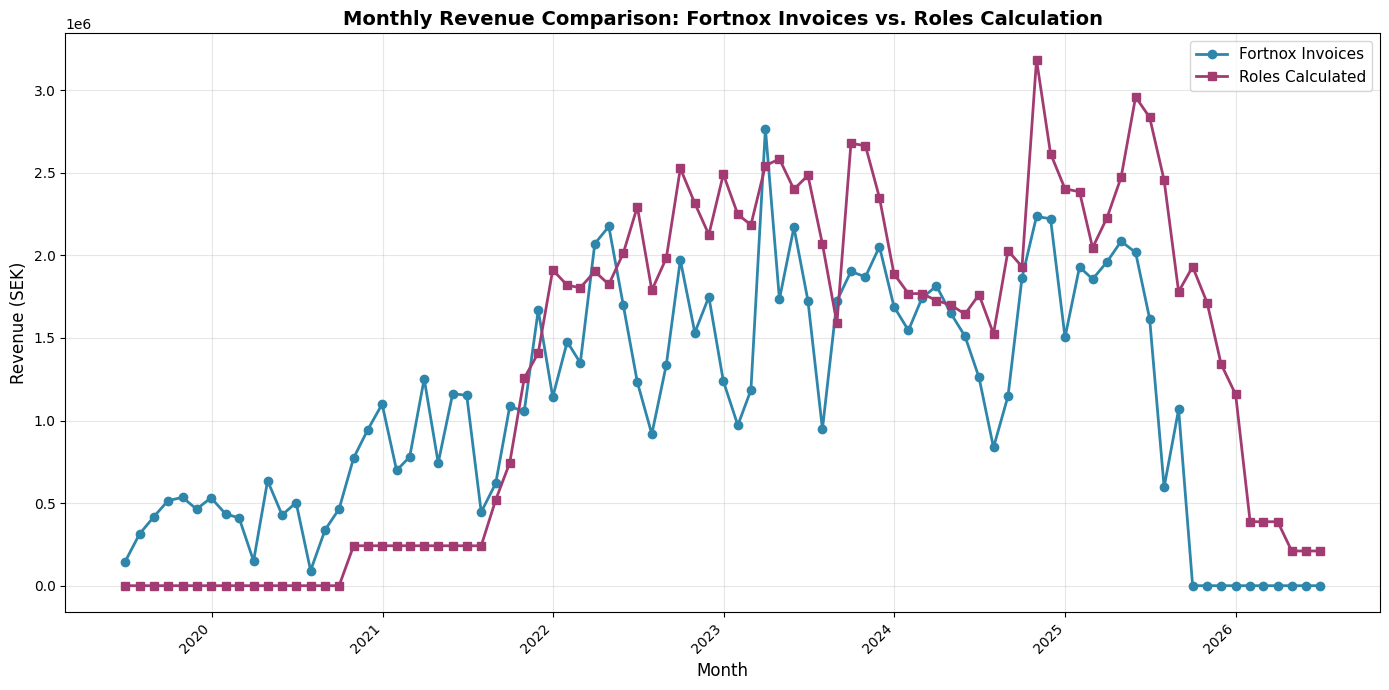

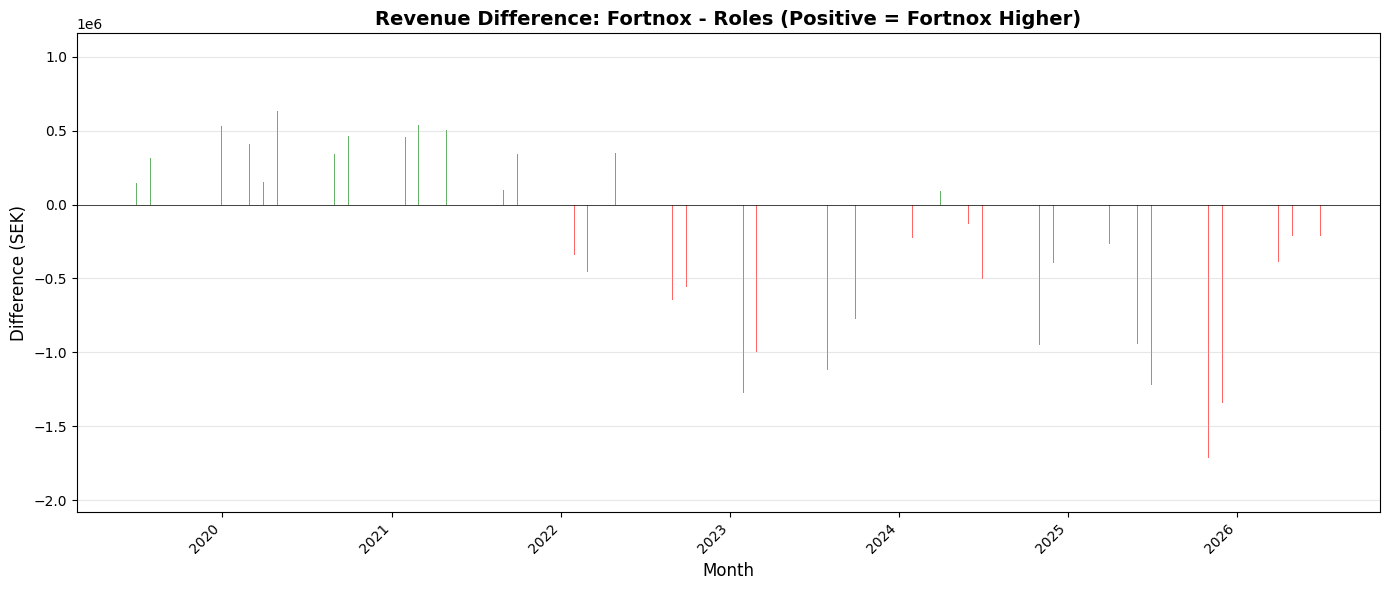

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from pathlib import Path

# Set up paths
REPO_ROOT = Path().resolve().parent if Path().resolve().name == 'notebooks' else Path().resolve()
RAW_DIR = REPO_ROOT / "data" / "raw"
LINKING_DIR = REPO_ROOT / "data" / "processed" / "linking_tables"

# Load Fortnox invoices
fortnox_path = RAW_DIR / "fct__fortnox_invoices__anonymized.csv"
fortnox = pd.read_csv(fortnox_path)
fortnox['invoice_date'] = pd.to_datetime(fortnox['invoice_date'], errors='coerce')

# Aggregate Fortnox revenue by month
fortnox_monthly = (
    fortnox.groupby(pd.Grouper(key='invoice_date', freq='ME'))['invoice_amount_total']
    .sum()
    .reset_index()
    .rename(columns={'invoice_date': 'date', 'invoice_amount_total': 'fortnox_revenue'})
)

# Load roles enriched data
roles_path = LINKING_DIR / "export__roles_enriched__20251006.csv"
roles = pd.read_csv(roles_path)

# Parse dates
roles['role_start_date'] = pd.to_datetime(roles['role_start_date'], errors='coerce')
roles['role_end_date'] = pd.to_datetime(roles['role_end_date'], errors='coerce')

# Calculate revenue per role
roles['hourly_rate'] = pd.to_numeric(roles['hourly_rate'], errors='coerce')
roles['required_hours'] = pd.to_numeric(roles['required_hours'], errors='coerce')
roles['total_revenue'] = roles['hourly_rate'] * roles['required_hours']

# For roles without end dates, use current date
roles['role_end_date'] = roles['role_end_date'].fillna(pd.Timestamp.now())

# Create monthly revenue from roles
# We'll distribute revenue across the months the role was active
monthly_roles_data = []

for idx, row in roles.iterrows():
    if pd.notna(row['role_start_date']) and pd.notna(row['total_revenue']) and row['total_revenue'] > 0:
        start = row['role_start_date']
        end = row['role_end_date']
        
        # Generate month-end dates for the role period
        month_range = pd.date_range(start=start.replace(day=1), end=end, freq='ME')
        
        if len(month_range) > 0:
            # Distribute revenue evenly across months
            revenue_per_month = row['total_revenue'] / len(month_range)
            
            for month in month_range:
                monthly_roles_data.append({
                    'date': month,
                    'revenue': revenue_per_month
                })

# Aggregate roles revenue by month
if monthly_roles_data:
    roles_monthly = (
        pd.DataFrame(monthly_roles_data)
        .groupby('date')['revenue']
        .sum()
        .reset_index()
        .rename(columns={'revenue': 'roles_revenue'})
    )
else:
    roles_monthly = pd.DataFrame(columns=['date', 'roles_revenue'])

# Merge both sources
comparison = fortnox_monthly.merge(roles_monthly, on='date', how='outer').sort_values('date')
comparison = comparison.fillna(0)

# Create visualization
plt.figure(figsize=(14, 7))

plt.plot(comparison['date'], comparison['fortnox_revenue'], 
         marker='o', linewidth=2, label='Fortnox Invoices', color='#2E86AB')
plt.plot(comparison['date'], comparison['roles_revenue'], 
         marker='s', linewidth=2, label='Roles Calculated', color='#A23B72')

plt.xlabel('Month', fontsize=12)
plt.ylabel('Revenue (SEK)', fontsize=12)
plt.title('Monthly Revenue Comparison: Fortnox Invoices vs. Roles Calculation', fontsize=14, fontweight='bold')
plt.legend(fontsize=11)
plt.grid(True, alpha=0.3)
plt.xticks(rotation=45, ha='right')
plt.tight_layout()

# Display summary statistics
print("Revenue Comparison Summary")
print("=" * 50)
print(f"\nFortnox Total Revenue: {comparison['fortnox_revenue'].sum():,.2f} SEK")
print(f"Roles Total Revenue: {comparison['roles_revenue'].sum():,.2f} SEK")
print(f"Difference: {(comparison['fortnox_revenue'].sum() - comparison['roles_revenue'].sum()):,.2f} SEK")
print(f"\nMonthly correlation: {comparison[['fortnox_revenue', 'roles_revenue']].corr().iloc[0, 1]:.3f}")

# Show comparison table
print("\n\nMonthly Breakdown (last 12 months):")
print(comparison.tail(12).to_string(index=False))

plt.show()

# Optional: Create a difference chart
plt.figure(figsize=(14, 6))
comparison['difference'] = comparison['fortnox_revenue'] - comparison['roles_revenue']
plt.bar(comparison['date'], comparison['difference'], 
        color=['green' if x >= 0 else 'red' for x in comparison['difference']], alpha=0.6)
plt.axhline(y=0, color='black', linestyle='-', linewidth=0.5)
plt.xlabel('Month', fontsize=12)
plt.ylabel('Difference (SEK)', fontsize=12)
plt.title('Revenue Difference: Fortnox - Roles (Positive = Fortnox Higher)', fontsize=14, fontweight='bold')
plt.xticks(rotation=45, ha='right')
plt.grid(True, alpha=0.3, axis='y')
plt.tight_layout()
plt.show()